In [3]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
plt.style.use('default')

import functools
import warnings

from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit

In [4]:
def flatten(func):
    ''' Decorator to flatten function parameters '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        flat_args = [a if a is None else a.flatten() for a in args]
        return func(*flat_args, **kwargs)
    return helper

def validate_shape(func):
	''' Decorator to flatten all function input arrays, and ensure shapes are the same '''
	@functools.wraps(func)
	def helper(*args, **kwargs):
		flat     = [a.flatten() if hasattr(a, 'flatten') else a for a in args]
		flat_shp = [a.shape for a in flat if hasattr(a, 'shape')]
		orig_shp = [a.shape for a in args if hasattr(a, 'shape')]
		assert(all(flat_shp[0] == s for s in flat_shp)), f'Shapes mismatch in {func.__name__}: {orig_shp}'
		return func(*flat, **kwargs)
	return helper

def only_finite(func):
	''' Decorator to remove samples which are nan in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(np.isfinite(stacked), 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper

def only_valid(func):
    ''' Decorator to remove all elements having a nan in any array '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        assert(all([len(a.shape) == 1 for a in args]))
        stacked = np.vstack(args)
        valid = np.all(np.isfinite(stacked), 0)
        return func(*stacked[:, valid], **kwargs)
    return helper

def only_positive(func):
	''' Decorator to remove samples which are zero/negative in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(stacked > 0, 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper


def label(name):
    ''' Label a function for when it's printed '''
    def helper(f):
        f.__name__ = name
        return f
    return helper

@only_finite
@label('RMSE')
def rmse(y, y_hat):
	''' Root Mean Squared Error '''
	return np.mean((y - y_hat) ** 2) ** .5


@only_finite
@only_positive
@label('RMSLE')
def rmsle(y, y_hat):
	''' Root Mean Squared Logarithmic Error '''
	return np.mean(np.abs(np.log(y) - np.log(y_hat)) ** 2) ** 0.5


@only_finite
@label('NRMSE')
def nrmse(y, y_hat):
	''' Normalized Root Mean Squared Error '''
	return ((y - y_hat) ** 2).mean() ** .5 / y.mean()

@only_finite
@only_positive
@label('R^2')
def r_squared(y, y_hat):
	''' Logarithmic R^2 '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return r_value**2

@label('<=0')
@flatten
@only_valid
def leqz(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return (y2 <= 0).sum()


@label('<=0|NaN')
@flatten
def leqznan(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return np.logical_or(np.isnan(y2), y2 <= 0).sum()

@label('MAD')
@flatten
@only_valid
def MAD(y1, y2):
    ''' Mean Absolute Error '''
    i  = np.logical_and(y1 > 0, y2 > 0)
    y1 = np.log10(y1[i])
    y2 = np.log10(y2[i])
    i  = np.logical_and(np.isfinite(y1), np.isfinite(y2))
    y1 = y1[i]
    y2 = y2[i]
    return 10**np.mean(np.abs(y1 - y2))-1

@only_finite
@label('MdAPE')
def mape(y, y_hat):
	''' Mean Absolute Percentage Error '''
	return 100 * np.median(np.abs((y - y_hat) / y))

@only_finite
@only_positive
@label('MSA')
def msa(y, y_hat):
	''' Mean Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.mean(np.abs(np.log(y_hat / y)))) - 1)


@only_finite
@only_positive
@label('MdSA')
def mdsa(y, y_hat):
	''' Median Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.median(np.abs(np.log(y_hat / y)))) - 1)

@only_finite
@only_positive
@label('SSPB')
def sspb(y, y_hat):
	''' Symmetric Signed Percentage Bias '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	M = np.median( np.log(y_hat / y) )
	return 100 * np.sign(M) * (np.exp(np.abs(M)) - 1)


@only_finite
@label('Bias')
def bias(y, y_hat):
	''' Mean Bias '''
	return np.mean(y_hat - y)

@only_finite
@only_positive
@label('Slope')
def slope(y, y_hat):
	''' Logarithmic slope '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return slope_


@only_finite
@only_positive
@label('Intercept')
def intercept(y, y_hat):
	''' Locarithmic intercept '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return intercept_

@validate_shape
@label('MWR')
def mwr(y, y_hat, y_bench):
	'''
	Model Win Rate - Percent of samples in which model has a closer
	estimate than the benchmark.
		y: true, y_hat: model, y_bench: benchmark
	'''
	y_bench[y_bench < 0] = np.nan
	y_hat[y_hat < 0] = np.nan
	y[y < 0] = np.nan
	valid = np.logical_and(np.isfinite(y_hat), np.isfinite(y_bench))
	diff1 = np.abs(y[valid] - y_hat[valid])
	diff2 = np.abs(y[valid] - y_bench[valid])
	stats = np.zeros(len(y))
	stats[valid]  = diff1 < diff2
	stats[~np.isfinite(y_bench)] = 1
	stats[~np.isfinite(y_hat)] = 0
	return stats.sum() / np.isfinite(y).sum()

def performance(key, y1, y2, metrics=[rmse, slope, msa, rmsle, sspb, MAD, leqznan]):#[rmse, rmsle, mape, r_squared, bias, mae, leqznan, slope]):
    ''' Return a string containing performance using various metrics.
        y1 should be the true value, y2 the estimated value. '''
    return '%8s | %s' % (key, '   '.join([
            '%s: %6.3f' % (f.__name__, f(y1,y2)) for f in metrics]))

In [20]:
pred_path = 'C:\\github_repos\\iop_nns\\pnn_model_estimates\\'
fig_save_path = 'C:\\github_repos\\iop_nns\\manuscript_figures\\'

In [11]:
# MDN, BNN DC, BNN MCD, ENS, RNN - RS, WD, OOD result estimates

mdn_wd = pd.read_csv(pred_path + 'mdn_wd_preds.csv')
mdn_ood = pd.read_csv(pred_path + 'mdn_ood_preds.csv')
dc_wd = pd.read_csv(pred_path + 'bnn_dropconnect_wd_preds.csv')
dc_ood = pd.read_csv(pred_path + 'bnn_dropconnect_ood_preds.csv')
mcd_wd = pd.read_csv(pred_path + 'bnn_mcd_wd_preds.csv')
mcd_ood = pd.read_csv(pred_path + 'bnn_mcd_ood_preds.csv')
ens_wd = pd.read_csv(pred_path + 'ensemble_wd_preds.csv')
ens_ood = pd.read_csv(pred_path + 'ensemble_ood_preds.csv')
rnn_wd = pd.read_csv(pred_path + 'rnn_wd_preds.csv')
rnn_ood = pd.read_csv(pred_path + 'rnn_ood_preds.csv')
dc_random = pd.read_csv(pred_path + 'bnn_dropconnect_random_split_preds.csv')
ens_random = pd.read_csv(pred_path + 'ensemble_random_split_preds.csv')
mdn_random = pd.read_csv(pred_path + 'mdn_random_split_preds.csv')
rnn_random = pd.read_csv(pred_path + 'rnn_random_split_preds.csv')
mcd_random = pd.read_csv(pred_path + 'bnn_mcd_random_split_preds.csv')

In [13]:
def calculate_percentage_from_category(df, category1, category2, columns_of_interest):
    """
    Filters two categories from the main dataframe, resets their indexes,
    selects the specific columns, and calculates the percentage of category1 over category2 for those columns.

    Parameters:
    - df: the main dataframe containing all data.
    - category1: the category for the numerator.
    - category2: the category for the denominator.
    - columns_of_interest: the IOPs to perform the operation on

    Returns:
    - A dataframe with the calculated percentages for the specified columns.
    """
    # Filter dataframes by category and reset indexes
    df_cat_reset_1 = df[df['Category'] == category1].reset_index(drop=True)
    df_cat_reset_2 = df[df['Category'] == category2].reset_index(drop=True)

    # Perform the operation on the specified columns
    result = np.abs(df_cat_reset_1[columns_of_interest] / df_cat_reset_2[columns_of_interest]) * 100

    return result

# Define the columns of interest
columns_of_interest = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

# Use the function to calculate percentages directly from the main dataframe
percent_total_uncertainty = calculate_percentage_from_category(mcd_ood, 'total_unc', 'pred_scaled_for_unc', columns_of_interest)
percent_aleatoric_uncertainty = calculate_percentage_from_category(mcd_ood, 'ale_unc', 'pred_scaled_for_unc', columns_of_interest)
percent_epistemic_uncertainty = calculate_percentage_from_category(mcd_ood, 'epi_unc', 'pred_scaled_for_unc', columns_of_interest)

# Other categories
pred_scaled = mcd_ood[mcd_ood['Category'] == 'pred_scaled_for_unc']
y_true = mcd_ood[mcd_ood['Category'] == 'y_true']
y_pred = mcd_ood[mcd_ood['Category'] == 'y_pred']
std_pred = mcd_ood[mcd_ood['Category'] == 'pred_std'].reset_index(drop=True)


In [14]:
# Ensure all dfs are loaded as defined previously
dataframes = {
    'mdn_wd': mdn_wd,
    'mdn_ood': mdn_ood,
    'mdn_random':mdn_random,
    'dc_wd': dc_wd,
    'dc_ood': dc_ood,
    'dc_random':dc_random,
    'mcd_wd': mcd_wd,
    'mcd_ood': mcd_ood,
    'mcd_random': mcd_random,
    'ens_wd': ens_wd,
    'ens_ood': ens_ood,
    'ens_random':ens_random,
    'rnn_wd' : rnn_wd,
    'rnn_ood' : rnn_ood,
    'rnn_random':rnn_random,
}

# subset
columns_of_interest = ['aCDOM_443', 'aCDOM_675', 'aph_443', 'aph_675']

def calculate_uncertainties_and_categories(df, columns_of_interest):
    result_dict = {
        'percent_total_uncertainty': calculate_percentage_from_category(df, 'total_unc', 'pred_scaled_for_unc', columns_of_interest),
        'percent_aleatoric_uncertainty': calculate_percentage_from_category(df, 'ale_unc', 'pred_scaled_for_unc', columns_of_interest),
        'percent_epistemic_uncertainty': calculate_percentage_from_category(df, 'epi_unc', 'pred_scaled_for_unc', columns_of_interest),
        'pred_scaled': df[df['Category'] == 'pred_scaled_for_unc'],
        'y_true': df[df['Category'] == 'y_true'],
        'y_pred': df[df['Category'] == 'y_pred'],
        'std_pred': df[df['Category'] == 'pred_std'].reset_index(drop=True)
    }
    return result_dict

# Apply the function to each df and store the results in a new dictionary
results = {df_name: calculate_uncertainties_and_categories(df, columns_of_interest) for df_name, df in dataframes.items()}


In [17]:
import numpy as np
import pandas as pd

def calculate_metrics(y_true, y_pred):
    # Ensure non-negative and non-zero filtering
    mask = (y_true > 1e-4) & (y_pred > 1e-4)
    y_true_filtered, y_pred_filtered = y_true[mask], y_pred[mask]

    if len(y_true_filtered) > 0 and np.all(y_true_filtered > 0) and np.all(y_pred_filtered > 0):  # Ensure positive data for log transformation
        # Log transformation
        log_y_true = np.log(y_true_filtered)
        log_y_pred = np.log(y_pred_filtered)

        # Calculate regression
        slope, intercept, r_value, p_value, std_err = linregress(log_y_true, log_y_pred)
        r_squared = r_value ** 2 

        return {
            'sspb': sspb(y_true_filtered, y_pred_filtered),
            'mdsa': mdsa(y_true_filtered, y_pred_filtered),
            'mape': mape(y_true_filtered, y_pred_filtered),
            'r_squared': r_squared
        }
    else:
        return {'sspb': None, 'mdsa': None, 'mape': None, 'r_squared': None}

metrics_results = {}

for name, result in results.items():
    metrics_df = pd.DataFrame(index=columns_of_interest, columns=['mdsa', 'sspb', 'r_squared'])

    for col in columns_of_interest:
        y_true = result['y_true'][col].values.flatten()  
        y_pred = result['y_pred'][col].values.flatten()
        metrics = calculate_metrics(y_true, y_pred)
        metrics_df.loc[col] = [metrics['mdsa'], metrics['sspb'], metrics['r_squared']]

    metrics_results[name + '_metrics'] = metrics_df

# The metrics_results dictionary now contains dfs with calculated metrics for each algorithm and variable

# Separating the results for the scenarios
random_metrics_results = {k: v for k, v in metrics_results.items() if '_random' in k}
wd_metrics_results = {k: v for k, v in metrics_results.items() if '_wd' in k}
ood_metrics_results = {k: v for k, v in metrics_results.items() if '_ood' in k}


### 1. Lollipop performance metrics

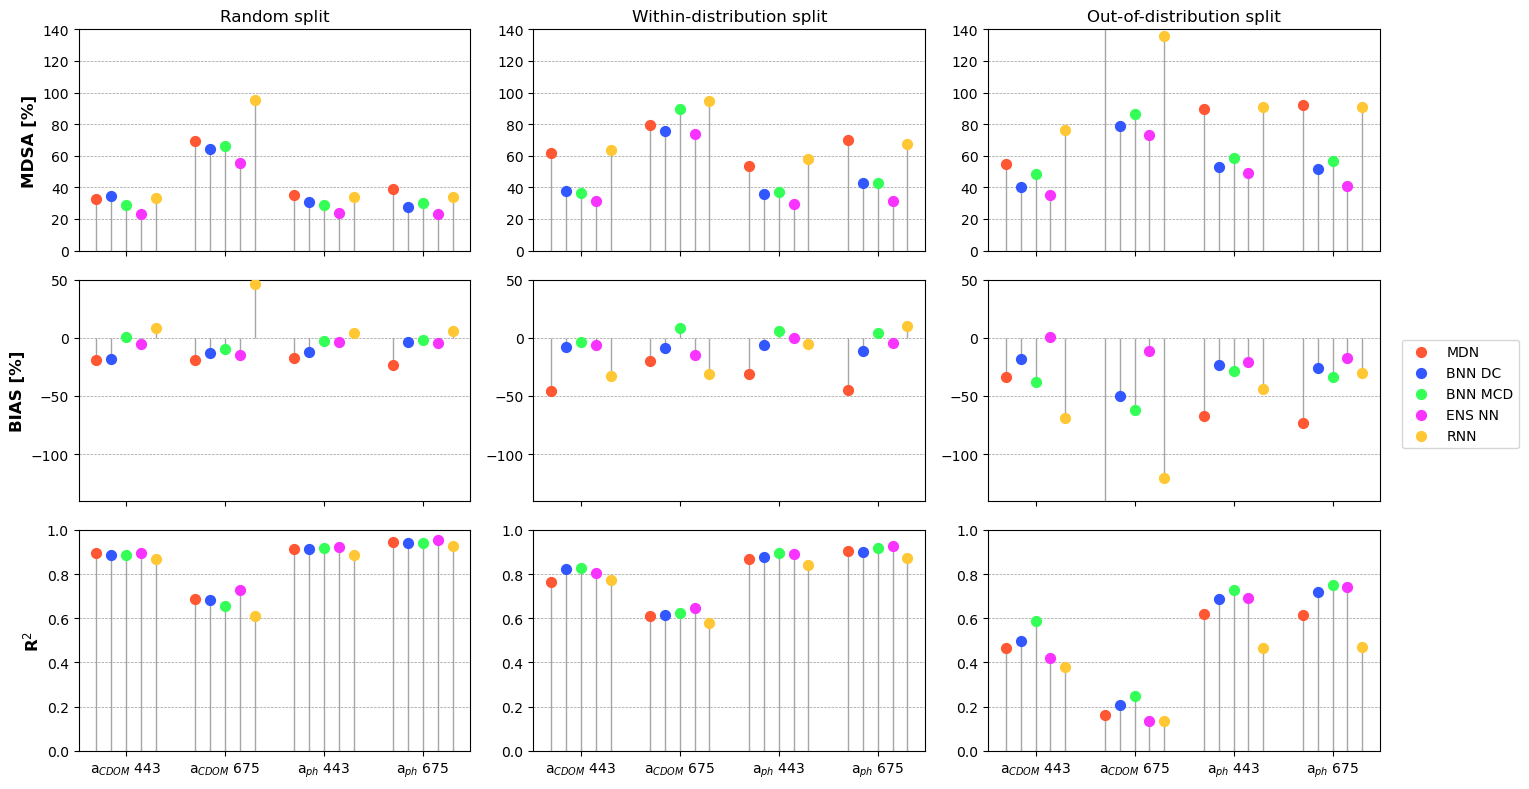

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define model colors for distinction
model_colors = {
    'mdn': '#FF5733',
    'mcd': '#33FF57',
    'dc': '#3357FF',
    'ens': '#F933FF',
    'rnn': '#FFC733'
}

# Metric display names and their data column names mapping
metrics_display = {
    'MDSA [%]': 'mdsa',
    'BIAS [%]': 'sspb',
    'R$^{2}$': 'r_squared'
}

# Custom y-axis labels and their limits
y_axis_labels = list(metrics_display.keys())
y_axis_limits = [(0, 140), (-140, 50), (0, 1)]

# Model and display titles for the variables
new_model_labels = ['MDN', 'BNN DC', 'BNN MCD', 'ENS NN', 'RNN']
display_titles = ['a$_{CDOM}$ 443', 'a$_{CDOM}$ 675', 'a$_{ph}$ 443', 'a$_{ph}$ 675']

def plot_horizontal_lollipop_charts(metrics_results_list, titles):
    n_groups = len(display_titles)
    n_metrics = len(metrics_display)
    n_models = len(metrics_results_list[0])  
    bar_width = 0.15
    opacity = 0.8

    fig, axs = plt.subplots(n_metrics, 3, figsize=(14, 8), sharex='col')
    #fig.suptitle("Performance Metrics", y=0.99, fontsize=16, fontweight='bold')

    for i, (metric_display, metric_column) in enumerate(metrics_display.items()):
        for j, metrics_results in enumerate(metrics_results_list):
            ax = axs[i, j]
            ax.set_ylim(y_axis_limits[i])

            for model_idx, (model_key, df) in enumerate(metrics_results.items()):
                model_short = model_key.split('_')[0]
                color = model_colors.get(model_short, 'gray')
                x = df[metric_column]
                y = np.arange(n_groups) - (bar_width * (n_models - 1) / 2) + model_idx * bar_width
                ax.scatter(y, x, color=color, label=new_model_labels[model_idx], s=50, zorder=3)  # Draw points
                ax.vlines(y, 0, x, colors='grey', lw=1, alpha=0.7)

            if j == 0:
                ax.set_ylabel(metric_display,fontweight='bold',fontsize=12)
            if i == 0:
                ax.set_title(titles[j])

            ax.set_xticks(np.arange(n_groups))
            ax.set_xticklabels(display_titles)
            ax.grid(True, which='both', linestyle='--', linewidth='0.5', color='black', alpha=0.4, axis='y')

    # Plot legend outside the subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(fig_save_path + 'performance_lolliplot_vertical.png',dpi=200,bbox_inches='tight')
    plt.show()

# Example usage with the revised function and hypothetical data structure
plot_horizontal_lollipop_charts([random_metrics_results, wd_metrics_results, ood_metrics_results], ['Random split', 'Within-distribution split', 'Out-of-distribution split'])
